In [51]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import seaborn as sns
import pandas as pd
import numpy as np
import json
import glob
import re
import matplotlib.pyplot as plt

In [60]:
folder = "logs/03_A"

lines = []
for file_name in glob.glob("*.log", root_dir=folder):
    with open(folder + "/" + file_name) as f:
        while line := f.readline():
            if "PFSTT" in line and "dashboard is deleting returned header" not in line:
                json_string = re.search(r'PFSTT(.*?)TTSFP', line).group(1)
                try:
                    lines.append(json.loads(json_string))
                except:
                    print("Error in file: " + file_name)
                    print("Line: " + line)
                    print("JSON: " + json_string)
                    print("-----")
                    continue

df = pd.DataFrame(lines)
# Set Data Types
df["start"] = df["start"].astype(float)
df["end"] = df["end"].astype(float)
df["request_timestamp"] = df["request_timestamp"].astype(float)
df["request_deadline"] = df["request_deadline"].astype(float)

# Calculate Durations
min_timestamp = df["request_timestamp"].min()
last_experiment_timestamp = df["end"].max()
df["request_timestamp"] = df["request_timestamp"] - min_timestamp
df["request_deadline"] = df["request_deadline"] - min_timestamp
df["start"] = df["start"] - min_timestamp
df["end"] = df["end"] - min_timestamp

# Add new columns
df["run_duration"] = df["end"] - df["start"]
df["time_to_deadline"] = df["request_deadline"] - df["start"]
df["init_duration"] = df["start"] - df["request_timestamp"]
df = df.sort_values(by=["function", "start"])
df["start_diff"] = df.groupby("function")["start"].diff()
df['line_segment'] = (df['start_diff'] > 5000).cumsum() # create a new line segment if there is a 5 second break
df

,function,start,end,callid,mode,request_timestamp,request_deadline,run_duration,time_to_deadline,init_duration,start_diff,line_segment
0,check,-4.348047e+01,1.520776e+01,2bb0d62171d541dcafd3d52a2ff215c1,sync,NaN,NaN,58.688232,NaN,NaN,NaN,0
1,check,1.026117e+03,1.069705e+03,3e733c8fd46c452989032e5b7a9a5139,sync,NaN,NaN,43.587891,NaN,NaN,1069.597168,0
2,check,2.099880e+03,2.137457e+03,e4463eb6820b44638ba44c705a547e85,sync,NaN,NaN,37.576660,NaN,NaN,1073.763184,0
3,check,3.000143e+03,3.040189e+03,651988e95d9342d49508b7340ae48971,sync,NaN,NaN,40.045654,NaN,NaN,900.263184,0
4,check,4.026703e+03,4.084266e+03,095dc66d67974949b056b28501210949,sync,NaN,NaN,57.562988,NaN,NaN,1026.559814,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1797,virus,1.185078e+06,1.185111e+06,796d4d736c734c3ab58e77b18e09e075,bored,895979.0,1075979.0,32.911621,-109098.610107,289098.610107,71.935547,70
1798,virus,1.185209e+06,1.185242e+06,3df7d238eef54b2a988910bb5a1f2561,bored,896978.0,1076978.0,33.744141,-108230.703125,288230.703125,131.093018,70
1799,virus,1.185331e+06,1.185363e+06,1fd8e4d09f534ca788e6e3c7c7f79a93,bored,898040.0,1078040.0,31.806885,-107290.770264,287290.770264,122.067139,70
1800,virus,1.185419e+06,1.185454e+06,eff2f53b5e764991b1e15cbc50d29503,bored,898999.0,1078999.0,34.281250,-106420.479492,286420.479492,88.709229,70


In [61]:
# If you want all CPU usage values in the df set this to False
ONLY_RELEVANT_CPU = True

smaller_dfs = []
for file_name in glob.glob("*.csv", root_dir="usage/"):
    # if ONLY_RELEVANT_CPU:
    #     start_ts = int(file_name.split("_")[3].split(".")[0])
    #     if start_ts > last_experiment_timestamp or start_ts < min_timestamp - 1000*60*60*24:
    #         continue
    with open("usage/" + file_name) as f:
        smaller_dfs.append(pd.read_csv(f))
usage_df = pd.concat(smaller_dfs)
usage_df["experiment_time"] = usage_df["unix_time"] - min_timestamp

if ONLY_RELEVANT_CPU:
    # Delete all values 10 seconds after the last call ended and 10 seconds before the first call started
    print("removed before:" + str(len(usage_df[usage_df["unix_time"] <= (last_experiment_timestamp + 10000)])))
    usage_df = usage_df[usage_df["unix_time"] <= (last_experiment_timestamp + 10000)]
    print("removed after:" + str(len(usage_df[usage_df["unix_time"] >= (min_timestamp - 10000)])))
    usage_df = usage_df[usage_df["unix_time"] >= (min_timestamp - 10000)]

usage_df

removed before:1236
removed after:767


,unix_time,cpu_percent,ram_percent,experiment_time
0,1695042130148,10.44,40.96,-6055.0
1,1695042132177,54.69,41.06,-4026.0
2,1695042134195,99.88,41.24,-2008.0
3,1695042136216,98.88,41.18,13.0
4,1695042138258,98.75,41.21,2055.0
...,...,...,...,...
762,1695043676655,100.00,51.09,1540452.0
763,1695043678683,100.00,51.60,1542480.0
764,1695043680708,100.00,53.04,1544505.0
765,1695043682736,100.00,53.25,1546533.0


In [48]:
min_timestamp

1694893136733.0

<Axes: xlabel='request_timestamp', ylabel='run_duration'>

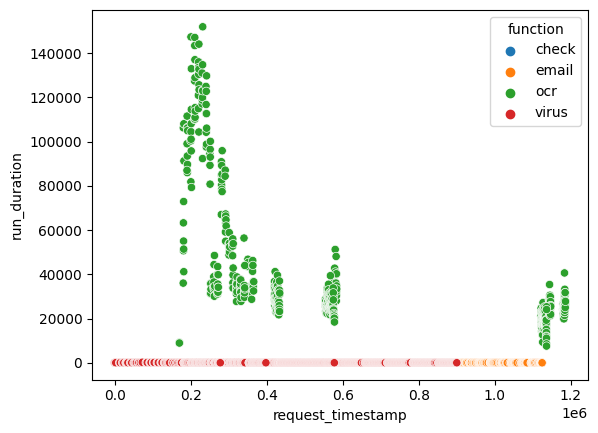

In [62]:
sns.scatterplot(data=df, x="request_timestamp", y="run_duration", hue="function")

<Axes: xlabel='request_timestamp'>

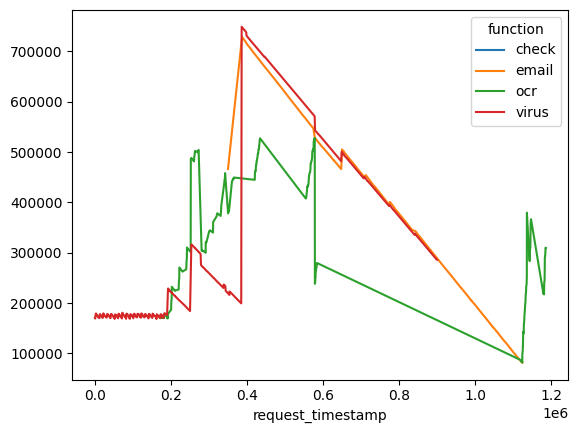

In [63]:
sns.lineplot(data=df, x="request_timestamp", y=df["start"]-df["request_timestamp"], hue="function")


<Axes: xlabel='experiment_time', ylabel='cpu_percent'>

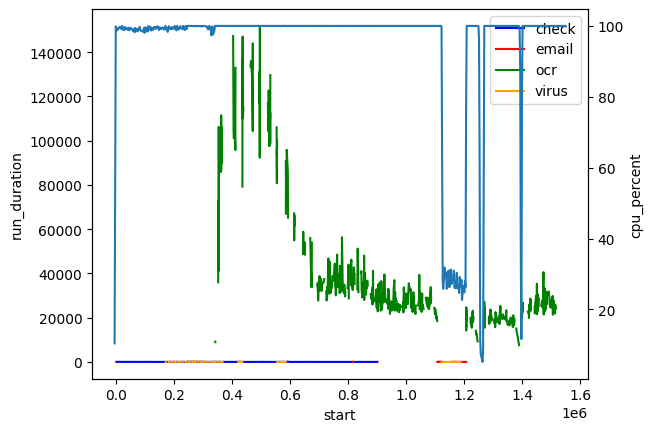

In [77]:
colors = {
    "check": "blue",
    "virus": "orange",
    "ocr": "green",
    "email": "red"
}
for (function, segment), group in df.groupby(["function", "line_segment"]):
    sns.lineplot(data=group, x="start", y="run_duration", color=colors[function], errorbar="ci", label=function, legend="brief")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax2 = plt.twinx()
sns.lineplot(ax=ax2, data=usage_df, x="experiment_time", y="cpu_percent")

<Axes: xlabel='experiment_time', ylabel='cpu_percent'>

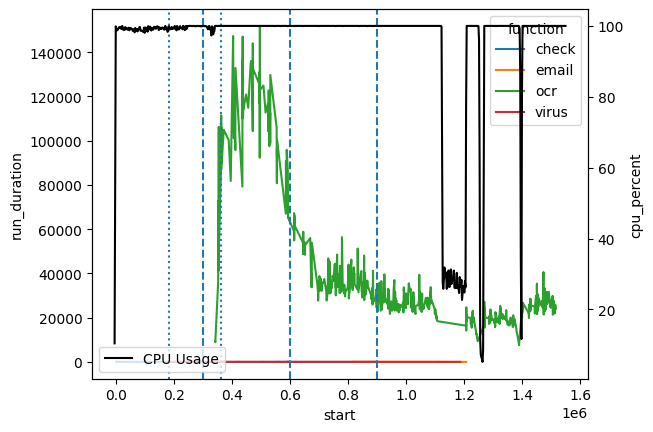

In [83]:
sns.lineplot(data=df, x="start", y="run_duration", hue="function")
plt.axvline(300_000, linestyle="dashed")
plt.axvline(600_000, linestyle="dashed")
plt.axvline(900_000, linestyle="dashed")
plt.axvline(180_000, linestyle="dotted")
plt.axvline(360_000, linestyle="dotted")
ax = plt.gca()
ax2 = plt.twinx()
sns.lineplot(ax=ax2, data=usage_df, x="experiment_time", y="cpu_percent", label="CPU Usage", color="black")


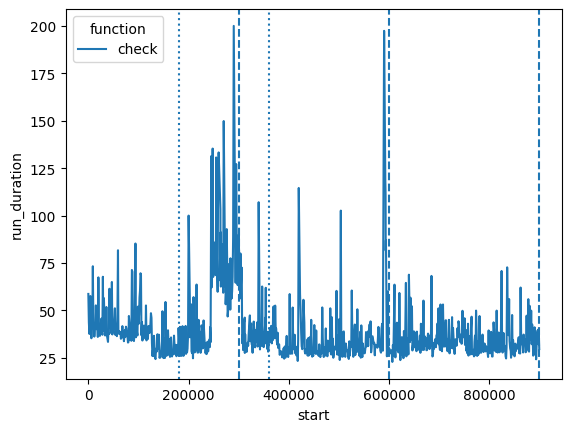

In [82]:
sns.lineplot(data=df[df["function"] == "check"], x="start", y="run_duration", hue="function")
plt.axvline(300_000, linestyle="dashed")
plt.axvline(600_000, linestyle="dashed")
plt.axvline(900_000, linestyle="dashed")
plt.axvline(180_000, linestyle="dotted")
plt.axvline(360_000, linestyle="dotted")

<Axes: xlabel='run_duration', ylabel='Proportion'>

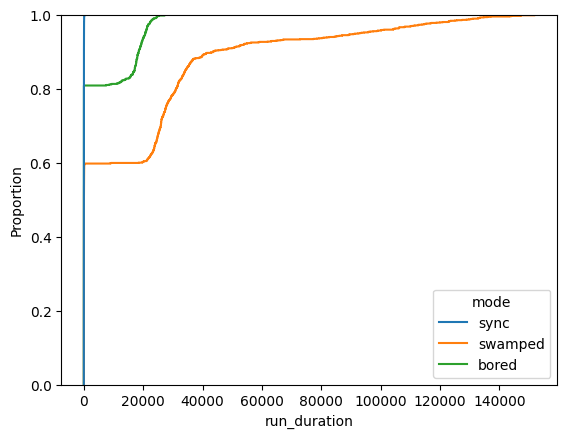

In [84]:
sns.ecdfplot(data=df, x="run_duration", hue="mode")